This is my (Padina)'s first attempt at creating/training a Computer Vision model for the 2025 CodeFest challenge #1
It aims to correctly classify garbage images for the purpose of recycling

The model is trained on the data found here:
https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2?resource=download

Note: This is the public version. The public version does not show my kaggle username and API.

To run this program, you need to include your own kaggle username and key, in step 1.1
Similarly, in the optional steps 7.3, 7.4 and 7.5, you should replace the variables path3 and path4 to the address in your google drive you want to save the model to.

# Step 0: Some Useful Libraries

In [ ]:
# importing some libraries which we will probably use later
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle
from PIL import Image
import cv2
import imghdr
import glob


# ensure any matplotlib graphs will be displayed inline
%matplotlib inline

import keras
import tensorflow as tf
from numpy.random import RandomState
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Step 1: Downloading Data

In [ ]:
# First step is to download the dataset directly from Kaggle
# Step 1.1 - add your kaggle info
import os
os.environ['KAGGLE_USERNAME'] = ""  # todo: add your username here
os.environ['KAGGLE_KEY'] = "" # todo: add your key here

In [ ]:
# Step 1.2: Install the Kaggle API client
!pip install kaggle

In [ ]:
# Step 1.3: Download garbage dataset
!kaggle datasets download -d sumn2u/garbage-classification-v2

Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 99% 738M/744M [00:09<00:00, 47.1MB/s]
100% 744M/744M [00:09<00:00, 82.6MB/s]


In [ ]:
# Step 1.4: Unzip the downloaded dataset
!unzip garbage-classification-v2.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage-dataset/paper/paper_847.jpg  
  inflating: garbage-dataset/paper/paper_848.jpg  
  inflating: garbage-dataset/paper/paper_849.jpg  
  inflating: garbage-dataset/paper/paper_851.jpg  
  inflating: garbage-dataset/paper/paper_852.jpg  
  inflating: garbage-dataset/paper/paper_853.jpg  
  inflating: garbage-dataset/paper/paper_855.jpg  
  inflating: garbage-dataset/paper/paper_856.jpg  
  inflating: garbage-dataset/paper/paper_857.jpg  
  inflating: garbage-dataset/paper/paper_859.jpg  
  inflating: garbage-dataset/paper/paper_861.jpg  
  inflating: garbage-dataset/paper/paper_863.jpg  
  inflating: garbage-dataset/paper/paper_865.jpg  
  inflating: garbage-dataset/paper/paper_868.jpg  
  inflating: garbage-dataset/paper/paper_870.jpg  
  inflating: garbage-dataset/paper/paper_871.jpg  
  inflating: garbage-dataset/paper/paper_873.jpg  
  inflating: garbage-dataset/paper/paper_874.jpg  
  inflating: garbage-dataset/pa

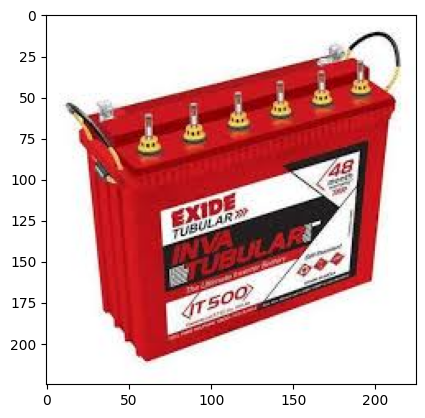

In [ ]:
# Loading a sample image
sample_image = Image.open(os.path.join('/content/garbage-dataset/battery/battery_101.jpg'))  # Load the image
plt.imshow(sample_image)
plt.show()

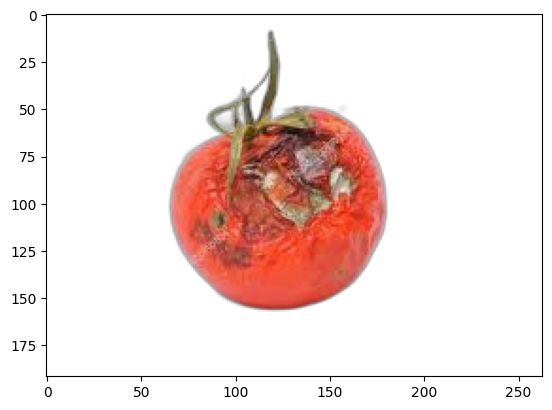

In [ ]:
# Another sample image this time with transparent background
my_path = '/content/garbage-dataset/biological/biological_10.jpg'
sample_image = Image.open(os.path.join(my_path))  # Load the image
plt.imshow(sample_image)

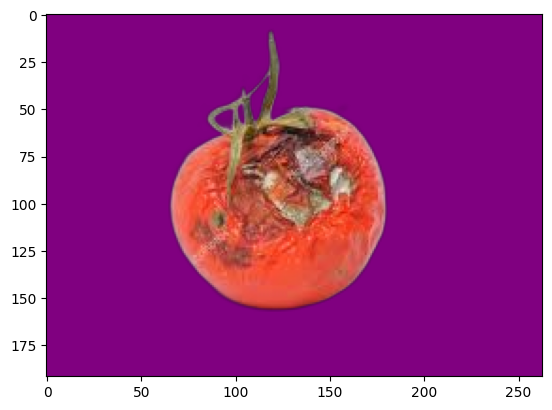

In [ ]:
# The same image as before, but now with a different background color
# Notice that since the image is partially transparent, the result now would look different

plt.imshow(sample_image)
plt.gca().set_facecolor('purple')  # Set the background color of the axes to purple
plt.show()

# Step 2: Dealing with the DATA

In [ ]:
# Step 2.1: Some useful variables

# The path for data directory on Collab
image_dir = '/content/garbage-dataset'

In [ ]:
# # NEW: Data cleaning and dealing with image types
# # Based on my measurements, most dataset images are in jpg format, 31 are png format, and a few were classified as other types
# # Therefor, since these images aren't too many, I will convert the png images to jpg, and drop any remainder images that are not of that type

# # Step 2.2: Let's convert png -> jpg
# # We will also deal with any transparency by converting the transparent parts to white (see step 2.- for more explanation)

# # convert_png_to_jpg function
# def convert_png_to_jpg(png_path):
#   img = Image.open(png_path)
#   if img.mode == "RGBA":  # If the image has transparency (ie: has an alpha channel)
#     background = Image.new("RGB", img.size, (255, 255, 255))  # Create a white background
#     background.paste(img, mask=img.split()[3])  # Paste image using the alpha channel as mask
#     img = background
#   jpg_path = png_path.replace(".png", ".jpg")
#   img.save(jpg_path, "JPEG", quality=95)
#   print(f"Converted: {png_path} → {jpg_path}")

In [ ]:
# # Convert all PNGs in all 10 folders
# base_path = '/content/garbage-dataset/'
# folder_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

# for folder_name in folder_names:
#   folder_path = base_path + folder_name

#   png_image_paths = glob.glob(os.path.join(folder_path, "*.png"))  # Find all PNG files
#   print(f"Processing {len(png_image_paths)} images in {folder_path}...")

#   # applying convert_png_to_jpg to each ong file
#   for file in png_image_paths:
#     convert_png_to_jpg(file)

#   print("All PNG images have been processed.")

In [ ]:
# Step 2.3: Dropping any remaining unexpected files
base_path = '/content/garbage-dataset/'
folder_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

count = 0
for folder_name in folder_names:
  folder_path = base_path + folder_name

  all_files = glob.glob(os.path.join(folder_path, "*"))

  for file in all_files:
    file_type = imghdr.what(file)  # Detect file format
    if file_type not in ["jpeg", "png", "jpg"]:
        print(f"Unknown image type: {file} (Detected as {file_type})")

        # Delete file from the dataset
        os.remove(file)
        print(f"{file} was successfully removed from dataset")
        count += 1

count

Unknown image type: /content/garbage-dataset/cardboard/cardboard_2088.jpg (Detected as None)
/content/garbage-dataset/cardboard/cardboard_2088.jpg was successfully removed from dataset
Unknown image type: /content/garbage-dataset/cardboard/cardboard_313.jpg (Detected as None)
/content/garbage-dataset/cardboard/cardboard_313.jpg was successfully removed from dataset
Unknown image type: /content/garbage-dataset/paper/paper_2184.jpg (Detected as None)
/content/garbage-dataset/paper/paper_2184.jpg was successfully removed from dataset
Unknown image type: /content/garbage-dataset/paper/paper_1678.jpg (Detected as webp)
/content/garbage-dataset/paper/paper_1678.jpg was successfully removed from dataset
Unknown image type: /content/garbage-dataset/paper/paper_2779.jpg (Detected as None)
/content/garbage-dataset/paper/paper_2779.jpg was successfully removed from dataset
Unknown image type: /content/garbage-dataset/paper/paper_2784.jpg (Detected as webp)
/content/garbage-dataset/paper/paper_278

12

In [ ]:
# Step 2.4: Getting rid of transparency
# Let's convert transparent pixels into white pixels.
# Images with transparent pixels have an Alpha channel in addition to RGB channels, linked to opaqueness

# I am choosing white pixels over black, as many images appear to already have white backgrounds
# and there are some categories that have more transparent-background elements than others (e.g. biological)
# I don't want to introduce a bias based on background color into the model

# Making the function remove_transparency
def remove_transparency(image_path, bg_color=(255, 255, 255)):  # White background by default
  img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # Load image with all channels (including alpha)
  if img.shape[-1] == 4:  # Has an alpha channel
    alpha = img[:, :, 3] / 255.0  # Normalize alpha to 0-1
    img_rgb = img[:, :, :3]  # Get RGB channels

    # Blend with white background --> ie: opaque pixels are unaffected, transparent pixels become white
    img_new = (1. - alpha[:, :, None]) * np.array(bg_color, dtype=np.float32) + alpha[:, :, None] * img_rgb
    img_new = img_new.astype(np.uint8)

    cv2.imwrite(image_path, img_new)  # Overwrite the image


In [ ]:
# Apply remove_transparency to all jpg images in all 10 folders
base_path = '/content/garbage-dataset/'
folder_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

for folder_name in folder_names:
  folder_path = base_path + folder_name

  image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))  # Find all JPG files
  # note: we can compare this print statement, to the number of dataset images shown by kaggle
  print(f"Processing {len(image_paths)} images in {folder_path}...")

  # applying remove_transparency to each file
  for file in image_paths:
    remove_transparency(file)

  print("All transparent images have been processed.")


Processing 944 images in /content/garbage-dataset/battery...
All transparent images have been processed.
Processing 997 images in /content/garbage-dataset/biological...
All transparent images have been processed.
Processing 1822 images in /content/garbage-dataset/cardboard...
All transparent images have been processed.
Processing 5326 images in /content/garbage-dataset/clothes...
All transparent images have been processed.
Processing 3054 images in /content/garbage-dataset/glass...
All transparent images have been processed.
Processing 1016 images in /content/garbage-dataset/metal...
All transparent images have been processed.
Processing 1672 images in /content/garbage-dataset/paper...
All transparent images have been processed.
Processing 1972 images in /content/garbage-dataset/plastic...
All transparent images have been processed.
Processing 1977 images in /content/garbage-dataset/shoes...
All transparent images have been processed.
Processing 938 images in /content/garbage-dataset/t

In [ ]:
# same with all png

for folder_name in folder_names:
  folder_path = base_path + folder_name

  image_paths = glob.glob(os.path.join(folder_path, "*.png"))  # Find all PNG files
  # note: we can compare this print statement, to the number of dataset images shown by kaggle
  print(f"Processing {len(image_paths)} images in {folder_path}...")

  # applying remove_transparency to each file
  for file in image_paths:
    remove_transparency(file)

  print("All transparent images have been processed.")


Processing 0 images in /content/garbage-dataset/battery...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/biological...
All transparent images have been processed.
Processing 1 images in /content/garbage-dataset/cardboard...
All transparent images have been processed.
Processing 1 images in /content/garbage-dataset/clothes...
All transparent images have been processed.
Processing 7 images in /content/garbage-dataset/glass...
All transparent images have been processed.
Processing 4 images in /content/garbage-dataset/metal...
All transparent images have been processed.
Processing 2 images in /content/garbage-dataset/paper...
All transparent images have been processed.
Processing 8 images in /content/garbage-dataset/plastic...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/shoes...
All transparent images have been processed.
Processing 8 images in /content/garbage-dataset/trash...
All transparent ima

In [ ]:
# and same with all jpeg

for folder_name in folder_names:
  folder_path = base_path + folder_name

  image_paths = glob.glob(os.path.join(folder_path, "*.jpeg"))  # Find all JPEG files
  # note: we can compare this print statement, to the number of dataset images shown by kaggle
  print(f"Processing {len(image_paths)} images in {folder_path}...")

  # applying remove_transparency to each file
  for file in image_paths:
    remove_transparency(file)

  print("All transparent images have been processed.")


Processing 0 images in /content/garbage-dataset/battery...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/biological...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/cardboard...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/clothes...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/glass...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/metal...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/paper...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/plastic...
All transparent images have been processed.
Processing 0 images in /content/garbage-dataset/shoes...
All transparent images have been processed.
Processing 1 images in /content/garbage-dataset/trash...
All transparent ima

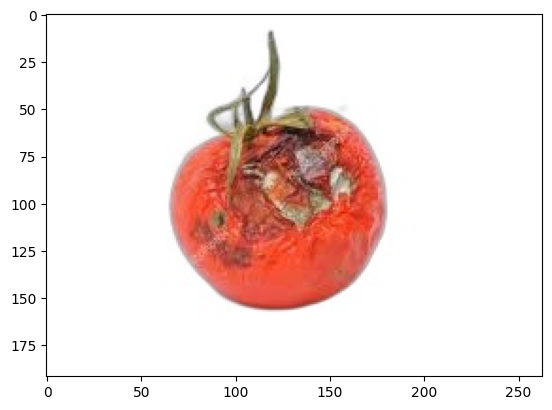

In [ ]:
# Let's test the same sample image as earlier again
# Now you can't see the purple background since it's no longer transparent

# Fetch the same sample image as before (but the updated version)
# Notice that since the image is partially transparent, the result now would look different
my_path = '/content/garbage-dataset/biological/biological_10.jpg'
sample_image = Image.open(os.path.join(my_path))

plt.imshow(sample_image)
plt.gca().set_facecolor('purple')  # Set the background color of the axes to purple
plt.show()

In [ ]:
# resizing variables - this ensures that everything is of the same square shaped size
# A glimpsing look at the data images shows that there are many different shapes and sizes
img_width = 250
img_height = 250

In [ ]:
# Step 2.3: Loading the resized shuffled dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=image_dir,
    image_size=(img_width, img_height),  # Resize images
    batch_size=32,
    shuffle=True,
    seed=25,  # Setting the random seed for reproducibility
    label_mode='int'
)

Found 19750 files belonging to 10 classes.


In [ ]:
full_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Printing the number of batches in the dataset
print(f"Total number of batches: {len(full_dataset)}")

Total number of batches: 618


In [ ]:
# Step 2.4: Saving the categories and their corresponding integers
category_list = full_dataset.class_names  # saving categories as a list
print(category_list)

['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [ ]:
# saving categories as a dictionary
category_dict = {i: category for i, category in enumerate(full_dataset.class_names)}
print(category_dict)

{0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'clothes', 4: 'glass', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'shoes', 9: 'trash'}


In [ ]:
# Note: Any further data cleaning/modification/augmentation, such as adding rotated images
# should be either done here, or after the train test split.

# However, while these changes are good ideas for the later expansion of the project,
# they are not implemented due to the time constraints of the CodeFest,
# and because they are not needed for the model to perform

# Step 3: Train Test Split
Splitting the data into train, validation, and test groups:
- Train: 70% of the dataset
- Val: 15% of the dataset
- Test: 15% of the dataset


Training and Validation data will be used during the actual training of the model. Testing data will be reserved for evaluating model performance after the training has completed.

Therefor the split ratio is:
70 : 15 : 15

In [ ]:
# Step 3.1: defining some values

# Dataset size
dataset_size = len(full_dataset)
print("Dataset Size: " + str(dataset_size))

# Split ratios
train_ratio = 0.7  # 70% training
val_ratio = 0.15  # 15% validation
test_ratio = 0.15  # 15% testing

# Split sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

Dataset Size: 618


In [ ]:
# Step 3.2: The actual splitting

# Split dataset
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size).take(val_size)
test_dataset = full_dataset.skip(train_size + val_size)

# Print dataset sizes
print(f"Train size: {len(train_dataset)} batches")
print(f"Validation size: {len(val_dataset)} batches")
print(f"Test size: {len(test_dataset)} batches")

Train size: 432 batches
Validation size: 92 batches
Test size: 94 batches


# Step 4: Creating the Model
For this version, let's create a sequencial model from scratch

We will be using Depthwise Separable Convolutions to create more efficient and resource friendly architectures

In [ ]:
# Step 4.1: Create Model !!!
model = models.Sequential()


# Step 4.2: Add a bunch of layers

# Note: Instead of just Conv2D convolutional layers, I am using Conv2D and DepthwiseConv2D
# which splits the convolution operation into two parts of filtering and combining
# This greatly reduces both the number of parameters and the computational cost.
# Batch normalization also helps to speed up training and improves model stability
# The Dense layer helps the model learn abstractions, but it is not TOO big to increase efficiency/reduce complexity
# I am using relatively small number of filters (16, 32, 64) as opposed to more (such as 512) to reduce complexity

# Input layer: Expecting images of shape (img_width, img_height, 3)
model.add(layers.InputLayer(input_shape=(img_width, img_height, 3)))

# Depthwise Separable Convolutions (lightweight) - this is similar to famous efficient models like MobileNet
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.DepthwiseConv2D((3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flattenning the feature maps
model.add(layers.Flatten())

# Adding a dense layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))  # Adding a dropout for regularization

# Output layer
model.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
# Step 4.3: Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 250, 250, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 250, 250, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 250, 250, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 125, 125, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 125, 125, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 62, 62, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,872,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,899,082 (30.13 MB)

 Trainable params: 7,898,858 (30.13 MB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
# Step 4.4: Compiling the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

# Step 5: Training the Model

In [ ]:
# Step 5.1: Defining the train_in_batches function
# Training in small batches ensures we don't run out of RAM space
# note since we've already defined batches in full_dataset, no need to do so here

def train_in_batches(model, train_dataset, val_dataset, num_epochs=10):

  print("everything ok so far")

  # Key Section: Train the Model!
  history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
  )

  print("everything still ok so far")

  return history


In [ ]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Step 5.2: Call train_in_batches() to actually train the model
# For now, let's train the model for a single epoch

num_epochs = 2

history = train_in_batches(model, train_dataset, val_dataset, num_epochs)

everything ok so far
Epoch 1/2
432/432 ━━━━━━━━━━━━━━━━━━━━ 2180s 5s/step - accuracy: 0.2813 - loss: 2.3197 - val_accuracy: 0.4290 - val_loss: 1.8420
Epoch 2/2
432/432 ━━━━━━━━━━━━━━━━━━━━ 2164s 5s/step - accuracy: 0.4629 - loss: 1.5950 - val_accuracy: 0.5299 - val_loss: 1.4300
everything still ok so far


In [ ]:
# # Let's train the model in for a few more epochs this allows us to save midway
# # Let's use loops because why not :)

# num_epochs = 1
# num_loops = 5

# for i in range(num_loops):
#   history = train_in_batches(model, train_dataset, val_dataset, num_epochs)

#   # Add code to save the model

Checking some optional useful metrics per epoch

Also note that these metrics are the average value per epoch.

So for example, if you run the model for a single epoch, the accuracy value it shows you is the average over all epochs and not the accuracy when evaluating the most recent batch

In [ ]:
# Step 5.3: Looking at training data and metrics --> Accuracy and Loss
# First, let's look at accuracy and loss rates of train data, per epoch

print(history.history['loss'])  # Loss for each epoch
print(history.history['accuracy'])  # Accuracy for each epoch

[2.032644510269165, 1.557928204536438]
[0.3424479067325592, 0.4739583432674408]


In [ ]:
# Now, let's look at accuracy and loss rates of validation data, per epoch

print(history.history['val_loss'])
print(history.history['val_accuracy'])

[1.842018485069275, 1.4300066232681274]
[0.4290081560611725, 0.529891312122345]


In [ ]:
# Step 5.4: Viewing precision, recall, and F1 score metrics during training
# precision: how many of the predicted positives, are true positives
 # (ie: ratio of correctly identified elements of a category vs everything that was predicted to be in that category)
# recall: how many actual positives were correctly identified
 # (ie: ratio of correctly identified elements of a category vs everything that was actually from that category)
# F1 rate is the mathematical mean between precision and recall

# # Here are the precision, recall, and F1 scores of the training data, per epoch
# print(history.history['precision'])  # Precision for each epoch
# print(history.history['recall'])  # Recall for each epoch
# print(history.history['f1_score'])  # F1 score for each epoch

KeyError: 'precision'

In [ ]:
# # And here are the precision, recall, and F1 scores of the valdiation data, per epoch

# print(history.history['val_precision'])
# print(history.history['val_recall'])
# print(history.history['val_f1_score'])

# Step 6: Testing and Evaluation

Running the model on the currently untouched test dataset, and looking at some metrics to evaluate its performance

In [ ]:
# Step 6.1 - Making predictions on the testing data

# setting up useful variables
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)  # Get model predictions
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert predicted probabilities to class labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# Step 6.2: Classification Report
# We can use sklearn Classification Report for more metrics, including precision, recall, and F1 rates
# precision: how many of the predicted positives, are true positives
  # (ie: ratio of correctly identified elements of a category vs everything that was predicted to be in that category)
# recall: how many actual positives were correctly identified
 # (ie: ratio of correctly identified elements of a category vs everything that was actually from that category)
# F1 rate is the mathematical mean between precision and recall


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.10      0.16       147
           1       0.61      0.27      0.37       148
           2       0.60      0.60      0.60       283
           3       0.64      0.92      0.75       806
           4       0.46      0.56      0.51       468
           5       0.11      0.02      0.03       174
           6       0.41      0.26      0.32       235
           7       0.51      0.37      0.43       306
           8       0.34      0.48      0.40       276
           9       0.51      0.32      0.40       139

    accuracy                           0.53      2982
   macro avg       0.46      0.39      0.40      2982
weighted avg       0.50      0.53      0.49      2982



In [ ]:
# Step 6.3: Confusion Matrix
# We can also generate a confusion matrix using sklearn
# This matrix helps us analyze false positives and negatives
c_matrix = confusion_matrix(y_true, y_pred)
print(c_matrix)

[[ 14   0   8  17  30   6   4   8  60   0]
 [  0  40  11  26  22   0   6   4  34   5]
 [  0   5 169  41  18   3   8   6  33   0]
 [  1   7   9 741  12   4  12   8  11   1]
 [  5   1  28  72 262   1  10  32  45  12]
 [  5   2  15  28  57   3  14  14  33   3]
 [  0   4   9  88  32   1  61  17  18   5]
 [  2   1  22  56  65   8  15 112  14  11]
 [  5   6   9  82  20   1   7   7 133   6]
 [  0   0   2  11  47   0  12  11  11  45]]


In [ ]:
# Step 6.4: Confusion Matrix using seaborn
# We can also use seaborn to make a nicer looking confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);



# Step 7: Saving the Model
Saving and exporting the model

Steps 7.1 and 7.2 save the model (in keras format and as a .h5). If ran on google colab, the model would be saved in the google colab files.

Steps 7.3, 7.4 and 7.5 are optional, but if you want to run them, they will save the model on your google drive. Note that you will need to allow access to your google drive, and update the save_paths to the desired address in your google drive.



todo: would this be ok in terms of local running?

In [ ]:
# Step 7.1: Save the entire model (including additional info needed for further training)
save_path1 = '/content/my_models/PadinaGarbageDetector1_6.keras'
# model.save(save_path1)
keras.saving.save_model(model, save_path1)

In [ ]:
# Step 7.2: Save the h5 model
save_path2 = '/content/my_models/PadinaGarbageDetector1_6.h5'
model.save(save_path2)

Optional steps 7.3, 7.4, 7.5 - you may uncomment them if you want to run them

In [ ]:
# # Step 7.3: Mount google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Step 7.4: Save the entire model on google drive (including additional info needed for further training)
# base_save_path = '' # Add your own path
# save_path3 = base_save_path + 'PadinaGarbageDetector1_6.keras'  # saved file name - update this for every new model
# keras.saving.save_model(model, save_path3)

In [ ]:
# # Step 7.5: Save the h5 model
# base_save_path = '' # Add your own path
# save_path4 = base_save_path + 'PadinaGarbageDetector1_6.h5'  # saved file name - update this for every new model
# model.save(save_path2)

# Step 8: Useful Functions
Function(s) used to run saved model on individual or bulk data, and return useful output - identified category, confidence level (eg. low confidence level could mean don't risk categorizing as recyclable), displaying top likely categories, category precentages, etc.

This section can also be done in, or copied into, a separate collab page to use the model without training